# PREDICTING VIEWERS' FEELING OF YOUTUBER'S STYLE USING NEURAL NETWORK
- Name: **Trần Thanh Dương (SE160185)**
- Class: **AIL302m**

This is my sample notebook about implementing Neural Network from scratch using `numpy`, `pandas`, `matplotlib` and some other `sklearn`'s functions in Python language.

In [ ]:
# Import some required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Dataset url
DATASET_URL = "https://gist.githubusercontent.com/duongttr/ff8728ebd7601e67c7d9eca1e86663ce/raw/02b90bb36befb7a7ca95747eaf21309511f796de/Food.csv"

## Data Cleaning
In this section, I will find out the structure of dataset and remove outliners.


In [ ]:
# Watch how the dataset look like
df = pd.read_csv(DATASET_URL)
df.head(10)

,e,no. video,Student ID,Full name,id,standardized dish,dish occurence (based on transcript),dish imply,start time,end time,...,sauce (based on transcript),venue,container,describe how to make it,viewer feeling of youtuber's style,viewer feeling of presented food,YouTuber feeling,location,foreigner,Unnamed: 24
0,1.0,51.0,NaN,NaN,5OzrpNCyXqs,snail vermicelli soup,bun oc,NaN,1:05,3:21,...,NaN,street restaurant,bowl,1,4,NaN,5,HN,1,NaN
1,2.0,51.0,NaN,NaN,5OzrpNCyXqs,vermicelli with fried tofu and shrimp paste,bun dau mam tom,NaN,3:32,6:10,...,"fish sauce, fermented shrimp paste, pepper, ch...",street restaurant,tray,1,4,NaN,4,HN,1,NaN
2,3.0,51.0,NaN,NaN,5OzrpNCyXqs,fried spring roll,spring roll,NaN,5:23,6:10,...,"fish sauce, sweet spicy garlic sauce",street restaurant,plate,0,5,NaN,5,HN,1,NaN
3,4.0,51.0,NaN,NaN,5OzrpNCyXqs,steamed rolled rice pancake,banh cuon,NaN,6:22,9:23,...,"garlic water, fried caramelized scallion, pepp...",street restaurant,plate,1,5,NaN,5,HN,1,NaN
4,5.0,51.0,NaN,NaN,5OzrpNCyXqs,shrimp cake,shrimp cake,NaN,9:42,11:55,...,"chili, sweet spicy sauce",street restaurant,plate,1,4,NaN,5,HN,1,NaN
5,6.0,51.0,NaN,NaN,5OzrpNCyXqs,boiled snail,snails cooked in lemongrass,ốc bươu hấp sả,12:28,15:17,...,"fish sauce, chili, lime leaves, garlic, lemong...",casual restaurant,bowl,0,5,NaN,5,HN,1,NaN
6,7.0,51.0,NaN,NaN,5OzrpNCyXqs,rolling pho,pho cuon,NaN,15:20,18:25,...,"sweet fish sauce, green papaya",street restaurant,plate,1,5,NaN,5,HN,1,NaN
7,8.0,51.0,NaN,NaN,5OzrpNCyXqs,pho,pho tron,phở gà trộn,19:10,22:33,...,NaN,street restaurant,bowl,1,5,NaN,5,HN,1,NaN
8,9.0,52.0,NaN,NaN,3qfTtx3yG5U,banh mi,banh mi,NaN,2:03,2:18,...,NaN,casual restaurant,bag,1,3,NaN,3,HN,1,NaN
9,10.0,52.0,NaN,NaN,3qfTtx3yG5U,egg coffee,coffee,NaN,2:26,2:52,...,NaN,casual restaurant,glass,0,4,NaN,4,HN,1,NaN


In [ ]:
# Required features for training model
features = ['start time', 'end time', 'Unnamed: 11', 'venue', 'container', 'describe how to make it',
            'viewer feeling of youtuber\'s style ']

After diving into the dataset, I found some following errors:

- The `start time` and `end time` contains some special cases (ex: `1.30`, `20;30`, `13 : 20`) and some unknown values (ie: `End`, `end`, `x`)
- Some datapoints have start `start time` and `end time` are equal.
- The `container` and `venue` have values which are out of specificed values (ie: `clay bot`, `Bag`, `no`, `home`, `boat restaurant`)

In [ ]:
import re

data = df[features].dropna() # Firstly, drop all NaN value in dataset

# Remove all unknown values
data = data[data['start time'].str.contains('start') == False]
data = data[data['start time'].str.contains('Start') == False]
data = data[data['end time'].str.contains('x') == False]
data = data[data['end time'].str.contains('end') == False]
data = data[data['end time'].str.contains('End') == False]
data = data[data['end time'].str.contains('x') == False]

# Rename columns' names
data = data.rename(columns={'Unnamed: 11': 'ingre_count', 'describe how to make it': 'is_described', 
             "viewer feeling of youtuber\'s style ": 'feeling'})

# Convert feeling type
data['feeling'] = data['feeling'].astype(int).replace({0: 1})

# Replace unspecificed values
data['venue'] = data['venue'].replace({'boat restaurant': 'other', 'home': 'other'})
data['container']=data['container'].replace(
              {'hand': 'hands-on', 'no': 'hands-on', 'clay bot': 'pot', 'tray ': 'tray',
              'plastic glass': 'glass', 'Bag': 'bag', 'cup': 'glass'})

data=data[data['is_described'] != '3']
data['is_described']=data['is_described'].astype(int)

# Calculate duration
pattern = '(\d+).*?[;:].*?(\d+)'
def calculate_duration(row):
  import re
  pattern = '(\d+).*?[;:.].*?(\d+)'
  start_time = row[0]
  end_time = row[1]

  try:
    start_min, start_sd = list(map(int, re.findall(pattern, start_time)[0]))
    end_min, end_sd = list(map(int, re.findall(pattern, end_time)[0]))
  except:
    print(row)
    return 0

  return end_min * 60 + end_sd - (start_min *60 + start_sd)

data['duration'] = data.apply(calculate_duration, axis=1)
data = data[data['duration'] > 0]

data=data.drop(labels=['start time', 'end time'], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3606 entries, 0 to 3849
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ingre_count   3606 non-null   int64 
 1   venue         3606 non-null   object
 2   container     3606 non-null   object
 3   is_described  3606 non-null   int64 
 4   feeling       3606 non-null   int64 
 5   duration      3606 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 197.2+ KB


# Data analysis
I will plot some distributions and charts for understanding more about dataset.

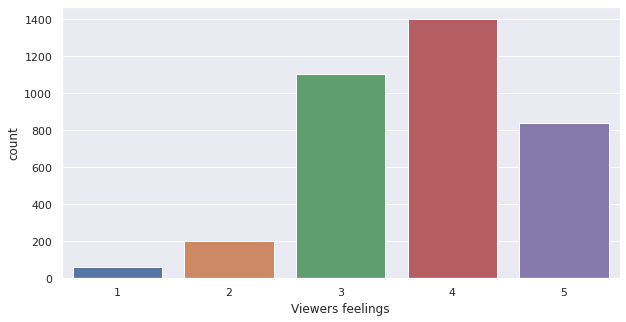

In [ ]:
# Viewers feeling counts
sns.set(rc = {'figure.figsize':(10, 5)})
sns.countplot(x='feeling', data=data)
plt.xlabel('Viewers feelings')
plt.show()

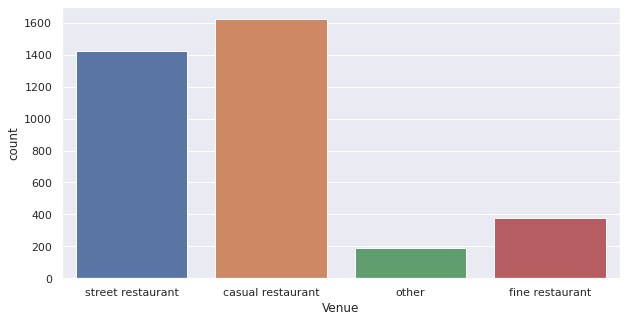

In [ ]:
# Venue counts
sns.countplot(x='venue', data=data)
plt.xlabel("Venue")
plt.show()

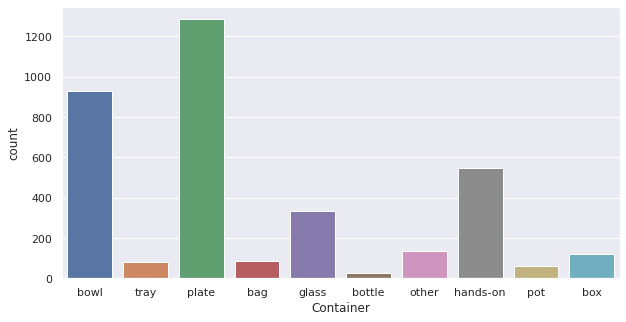

In [ ]:
# Container counts
sns.countplot(x='container', data=data)
plt.xlabel('Container')
plt.show()

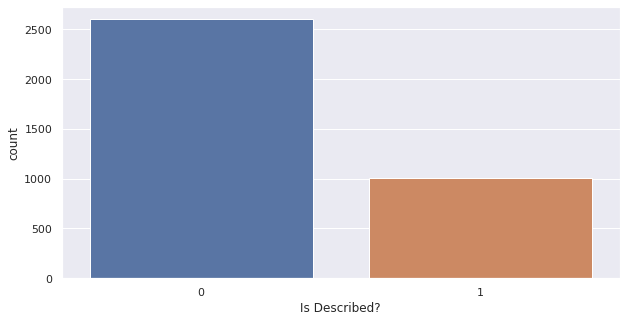

In [ ]:
# Is Described? counts
sns.countplot(x='is_described', data=data)
plt.xlabel('Is Described?')
plt.show()

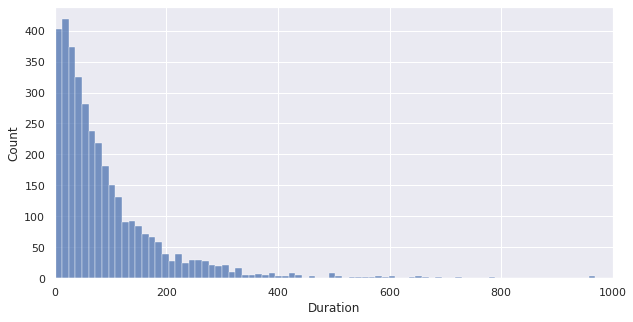

In [ ]:
# Duration distribution
sns.histplot(x='duration', data=data)
plt.xlim(0, 1000)
plt.xlabel('Duration')
plt.show()

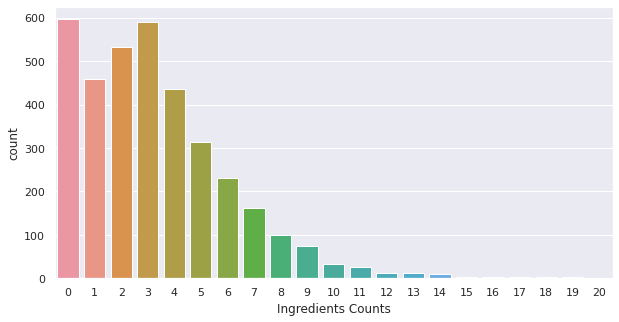

In [ ]:
# Ingredients Counts
sns.countplot(x='ingre_count', data=data)
plt.xlabel('Ingredients Counts')
plt.show()

## Data preprocessing
In this section, I will convert data string by using one-hot encoder for 2 features `container` and `venue` and upsampling data using RandomOverSampling.

In [ ]:
data['venue']=data['venue'].replace({v: k for k, v in dict(enumerate(data['venue'].unique())).items()})
data['container']=data['container'].replace({v: k for k, v in dict(enumerate(data['container'].unique())).items()})

onehot_venue = pd.get_dummies(data['venue'], 'venue')
onehot_container = pd.get_dummies(data['container'], 'container')

data=data.drop(labels=['venue', 'container'], axis=1)
data=data.join([onehot_venue, onehot_container])

In [ ]:
data.head(10)

,ingre_count,is_described,feeling,duration,venue_0,venue_1,venue_2,venue_3,container_0,container_1,container_2,container_3,container_4,container_5,container_6,container_7,container_8,container_9
0,9,1,4,136,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,11,1,4,158,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4,0,5,47,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,5,1,5,181,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,4,1,4,133,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5,5,0,5,169,0,1,0,0,1,0,0,0,0,0,0,0,0,0
6,7,1,5,185,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7,17,1,5,203,1,0,0,0,1,0,0,0,0,0,0,0,0,0
8,5,1,3,15,0,1,0,0,0,0,0,1,0,0,0,0,0,0
9,3,0,4,26,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Oversampling
y = data['feeling']
X = data.drop('feeling', axis=1)
#X, y = RandomOverSampler(random_state=99).fit_resample(X, y)

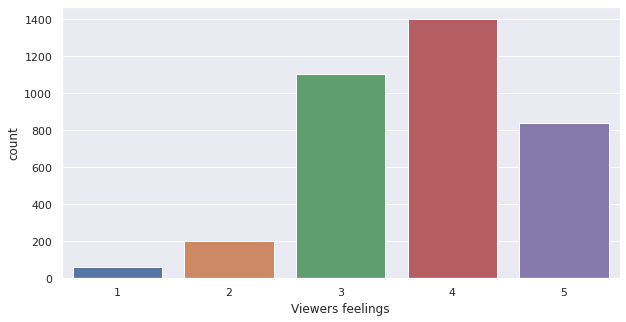

4    1400
3    1103
5     839
2     201
1      63
Name: feeling, dtype: int64

In [ ]:
# Watching the data now!
sns.countplot(x=y)
plt.xlabel('Viewers feelings')
plt.show()

y.value_counts()

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.2, stratify=y)

y_train = y_train.to_numpy() - np.ones_like(y_train)
y_test = y_test.to_numpy() - np.ones_like(y_test)

X_train, y_train = RandomOverSampler(random_state=99).fit_resample(X_train, y_train)

In [ ]:
# Scale data
std_scaler = StandardScaler()
X_train[['ingre_count', 'duration']] = std_scaler.fit_transform(X_train[['ingre_count', 'duration']])
X_test[['ingre_count', 'duration']] = std_scaler.transform(X_test[['ingre_count', 'duration']])

## Neural Network from Scratch

In [ ]:
from sklearn.utils import shuffle

class Dense:
    def __init__(self, neurons):
        self.neurons = neurons
        
    def relu(self, inputs):
        return np.maximum(0, inputs)

    def softmax(self, inputs):
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
    def relu_derivative(self, dA, Z):
        dZ = dA.copy()
        dZ[Z <= 0] = 0
        return dZ
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
      if activation == 'softmax': # softmax
          dW = np.dot(A_prev.T, dA_curr)
          db = np.sum(dA_curr, axis=0, keepdims=True)
          dA = np.dot(dA_curr, W_curr) 
      elif activation == 'relu': # relu
          dZ = self.relu_derivative(dA_curr, Z_curr)
          dW = np.dot(A_prev.T, dZ)
          db = np.sum(dZ, axis=0, keepdims=True)
          dA = np.dot(dZ, W_curr)
          
      return dA, dW, db
    
    def forward(self, inputs, weights, bias, activation):
        Z_curr = np.dot(inputs, weights.T) + bias
        
        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)
            
        return A_curr, Z_curr

class Network:
    def __init__(self):
        self.network = [] ## layers
        self.architecture = [] ## mapping input neurons --> output neurons
        self.params = [] ## W, b
        self.last_params = [] # lW, lb
        self.memory = [] ## Z, A
        self.gradients = [] ## dW, db
        
    def add(self, layer):
        self.network.append(layer)
            
    def _compile(self, data):
        for idx, layer in enumerate(self.network):
            # apply relu to all layers except the last one
            if idx == 0:
                self.architecture.append({'input_dim':data.shape[1], 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            elif idx > 0 and idx < len(self.network)-1:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            else:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'softmax'})
        return self
    
    def _initialize_weights(self, data):
        self._compile(data)
        
        np.random.seed(99) # random state
        
        for i in range(len(self.architecture)):
            self.params.append({
                'W':np.random.uniform(-2, 2, 
                  size=(self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim'])),
                'b':np.zeros((1, self.architecture[i]['output_dim']))})
            
            self.last_params.append({
                'lW':np.zeros((self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim'])),
                'lb':np.zeros((1, self.architecture[i]['output_dim']))})
        
        return self
    
    def _forwardprop(self, data):
        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, 
                                                     weights=self.params[i]['W'],
                                                     bias=self.params[i]['b'],
                                                     activation=self.architecture[i]['activation'])
            

            self.memory.append({'inputs':A_prev, 'Z':Z_curr})
            
        return A_curr
    
    def predict(self, data):
        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, weights=self.params[i]['W'],
                                                     bias=self.params[i]['b'], 
                                                     activation=self.architecture[i]['activation'])
            
        return A_curr
    
    def _backprop(self, predicted, actual):
        num_samples = len(actual)

        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples
        
        dA_prev = dscores

        for idx, layer in reversed(list(enumerate(self.network))):
            dA_curr = dA_prev
            
            A_prev = self.memory[idx]['inputs']
            Z_curr = self.memory[idx]['Z']
            W_curr = self.params[idx]['W']
            
            activation = self.architecture[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev, activation)

            self.gradients.append({'dW':dW_curr, 'db':db_curr})
            
    def _update(self):
        for idx, layer in enumerate(self.network):

            # momentum here
            new_change_W = self.lr * list(reversed(self.gradients))[idx]['dW'].T + self.momentum * self.last_params[idx]['lW']
            new_change_b = self.lr * list(reversed(self.gradients))[idx]['db'] + self.momentum * self.last_params[idx]['lb']
            self.params[idx]['W'] -= new_change_W
            self.params[idx]['b'] -= new_change_b

            self.last_params[idx]['lW'] = new_change_W
            self.last_params[idx]['lb'] = new_change_b
    
    def _get_accuracy(self, predicted, actual):
        return np.mean(np.argmax(predicted, axis=1)==actual)
    
    def _get_loss(self, predicted, actual):
        samples = len(actual)
        correct_logprobs = -np.log(predicted[range(samples),actual] + 10e-8)
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss
    
    def fit(self, X_train, y_train, 
              validation_data:tuple=None, 
              epochs:int=100, 
              lr:float=0.01, 
              momentum=0.99,
              verbose:bool=True):
        self.lr = lr
        self.momentum = momentum
        self.loss = []
        self.acc = []
        self.val_loss = []
        self.val_acc = []
        
        if validation_data:
          X_valid, y_valid = validation_data
        
        self._initialize_weights(X_train)

        for i in range(epochs):
            shuffle(X_train, y_train)
            yhat = self._forwardprop(X_train)
            self.acc.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._get_loss(predicted=yhat, actual=y_train))
            self._backprop(yhat, y_train)
            self._update()
            
            if validation_data:
              valid_yhat = self._forwardprop(X_valid)
              self.val_acc.append(self._get_accuracy(predicted=valid_yhat, actual=y_valid))
              self.val_loss.append(self._get_loss(predicted=valid_yhat, actual=y_valid))
            if verbose and i % 200 == 0:
                s = 'epochs: {} - acc: {:.4f} - loss: {:.4f} - val_acc: {:.4f} - val_loss: {:.4f}'.format(i, self.acc[-1], self.loss[-1], self.val_acc[-1], self.val_loss[-1])
                print(s)
            
            self.memory = []
            self.gradients = []

In [ ]:
# Initialize model with 3 layers
model = Network()
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(5))

In [ ]:
# I implemented SGD with momentum(=0.9) optimizers with learning_rate=0.001 
# and trained with 8,400 epochs
LR = 0.009
EPOCHS = 8400
MOMENTUM = 0.9

model.fit(X_train.to_numpy(), y_train, 
            validation_data=(X_test.to_numpy(), y_test), 
            epochs=EPOCHS, lr=LR, momentum=MOMENTUM)

epochs: 0 - acc: 0.2161 - loss: 11.9460 - val_acc: 0.0679 - val_loss: 14.5231
epochs: 200 - acc: 0.4700 - loss: 1.3044 - val_acc: 0.2770 - val_loss: 1.7261
epochs: 400 - acc: 0.4977 - loss: 1.1795 - val_acc: 0.3102 - val_loss: 1.5930
epochs: 600 - acc: 0.5005 - loss: 1.1275 - val_acc: 0.3186 - val_loss: 1.5640
epochs: 800 - acc: 0.5291 - loss: 1.0978 - val_acc: 0.3227 - val_loss: 1.5563
epochs: 1000 - acc: 0.5302 - loss: 1.0764 - val_acc: 0.3241 - val_loss: 1.5529
epochs: 1200 - acc: 0.5402 - loss: 1.0601 - val_acc: 0.3241 - val_loss: 1.5549
epochs: 1400 - acc: 0.5457 - loss: 1.0427 - val_acc: 0.3255 - val_loss: 1.5590
epochs: 1600 - acc: 0.5554 - loss: 1.0299 - val_acc: 0.3241 - val_loss: 1.5623
epochs: 1800 - acc: 0.5579 - loss: 1.0181 - val_acc: 0.3172 - val_loss: 1.5680
epochs: 2000 - acc: 0.5686 - loss: 1.0088 - val_acc: 0.3199 - val_loss: 1.5695
epochs: 2200 - acc: 0.5696 - loss: 1.0008 - val_acc: 0.3255 - val_loss: 1.5720
epochs: 2400 - acc: 0.5714 - loss: 0.9932 - val_acc: 0.32

## Evaluation model

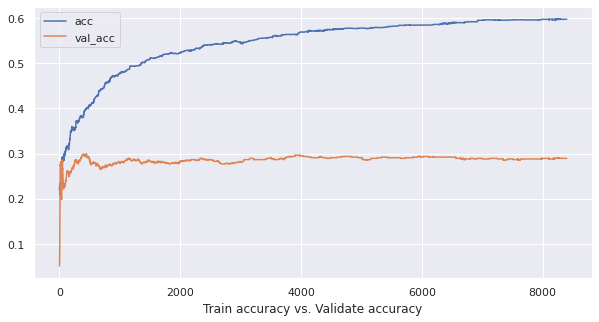

In [ ]:
# Plotting accuracy
sns.lineplot(x=range(1, len(model.acc)+1), y=model.acc)
sns.lineplot(x=range(1, len(model.val_acc)+1), y=model.val_acc)
plt.legend(['acc', 'val_acc'])
plt.xlabel('Train accuracy vs. Validate accuracy')
plt.show()

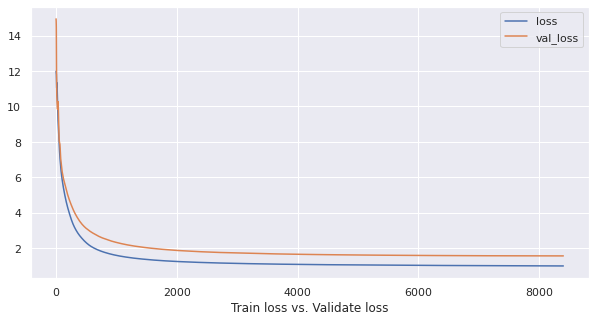

In [ ]:
# Plotting loss
sns.lineplot(x=range(1, len(model.loss)+1), y=model.loss)
sns.lineplot(x=range(1, len(model.val_loss)+1), y=model.val_loss)
plt.legend(['loss', 'val_loss'])
plt.xlabel('Train loss vs. Validate loss')
plt.show()

F1 score: 0.29


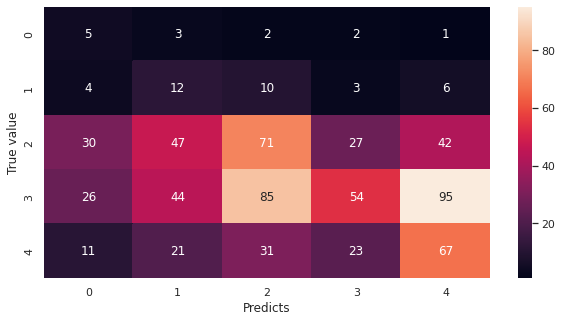

In [ ]:
# F1-Score and Confusion matrix
from sklearn.metrics import confusion_matrix, f1_score
y_pred = model.predict(X_test)

print("F1 score: {:.2}".format(f1_score(y_test,np.argmax(y_pred, axis=1), average='micro')))
sns.heatmap(confusion_matrix(y_test, np.argmax(y_pred, axis=1)), annot=True)
plt.xlabel('Predicts')
plt.ylabel('True value')
plt.show()